# Customizing embeddings
 According to ideas in the [ConceptFusion](https://concept-fusion.github.io/assets/pdf/2023-ConceptFusion.pdf) paper, when we mix information from global embeddings and local embeddings, we can better capture fine-grained and long-tailed concepts.

 This would be an obvious boon to the code search process.
 
 Data-handling code credit: https://github.com/openai/openai-cookbook/blob/main/examples/Customizing_embeddings.ipynb



In [23]:
# imports
from typing import List, Tuple  # for type hints
from scipy import stats
import os
import time
import json
import numpy as np  # for manipulating arrays
import pandas as pd  # for manipulating data in dataframes
import pickle  # for saving the embeddings cache
import plotly.express as px  # for plots
import matplotlib.pyplot as plt
import random  # for generating run IDs
from sklearn.model_selection import train_test_split  # for splitting train & test data
import torch  # for matrix optimization
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity  # for embeddings
import math

In [22]:
os.environ["OPENAI_API_KEY"] = # insert your API key here

## Loading Dataset
Assumes that data is loaded from v1-alpha-full/ in the same directory.

In [91]:
dataset = {"text_1": [], "text_2": [], "label": [], "readme": []}
for file in os.listdir("v1-alpha-full/"):
    if file.endswith(".json"):
        with open("v1-alpha-full/" + file) as f:
            data_dict = json.load(f)
        for example in data_dict["examples"]:
            for query in example["queries"]:
                dataset["text_1"].append(query)
                dataset["text_2"].append(example["code"])
                dataset["label"].append(1)
                dataset["readme"].append(data_dict["usable_readme"])
df = pd.DataFrame.from_dict(dataset)
df

,text_1,text_2,label,readme
0,Is there a way to check for structural equival...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...
1,What methods in this code block are responsibl...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...
2,What is the logic behind checking for structur...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...
3,What is the logic behind the cycle_equals func...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...
4,How does this code handle cycles when checking...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...
...,...,...,...,...
208380,What is the behavior of the Sample and LongDel...,```jcabi/jcabi-aspects/src/test/java/com/jcabi...,1,"<img src=""http://img.jcabi.com/logo-square.png..."
208381,What is the behavior of the Sample and LongDel...,```jcabi/jcabi-aspects/src/test/java/com/jcabi...,1,"<img src=""http://img.jcabi.com/logo-square.png..."
208382,Is there a way to use the AOP aspects in this ...,```jcabi/jcabi-aspects/src/test/java/com/jcabi...,1,"<img src=""http://img.jcabi.com/logo-square.png..."
208383,What is the behavior of the `ScheduleWithFixed...,```jcabi/jcabi-aspects/src/test/java/com/jcabi...,1,"<img src=""http://img.jcabi.com/logo-square.png..."


In [92]:
# input parameters
embedding_cache_path = (
    "data/snli_embedding_cache.pkl"  # embeddings will be saved/loaded here
)
embedding_cache_path2 = (
    "data/snli_embedding_cache2.pkl"  # embeddings will be saved/loaded here
)
default_embedding_engine = (
    "babbage-similarity"  # choice of: ada, babbage, curie, davinci
)
num_pairs_to_embed = (
    30  # 1000 is arbitrary - I've gotten it to work with as little as ~100
)
local_dataset_path = "data/snli_1.0_train_2k.csv"  # download from: https://nlp.stanford.edu/projects/snli/


def process_input_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.head(num_pairs_to_embed)
    return df


df = process_input_data(df)  # this demonstrates training data containing only positives
# view data
df.head()

,text_1,text_2,label,readme
0,Is there a way to check for structural equival...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...
1,What methods in this code block are responsibl...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...
2,What is the logic behind checking for structur...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...
3,What is the logic behind the cycle_equals func...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...
4,How does this code handle cycles when checking...,```cliffclick/aa/src/main/java/com/cliffc/aa/H...,1,# aa\n\nCliff Click Language Hacking\n========...


## Fusing local and global features
Inspecting the lengths of the code, it looks like 10 chunks is good enough:

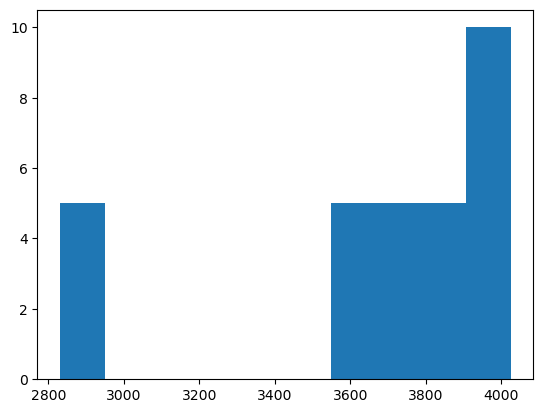

In [29]:
plt.hist(df.text_2.str.len())
N = 10

### Testing the method on one datapoint

In [51]:
test_query, test_code, test_readme = df.text_1[20], df.text_2[20], df.readme[20]

In [65]:
embedding_cache_path = (
    "data/snli_embedding_cache.pkl"  # embeddings will be saved/loaded here
)
try:
    with open(embedding_cache_path, "rb") as f:
        embedding_cache = pickle.load(f)
except FileNotFoundError:
    precomputed_embedding_cache_path = (
        "https://cdn.openai.com/API/examples/data/snli_embedding_cache.pkl"
    )
    embedding_cache = pd.read_pickle(precomputed_embedding_cache_path)


# this function will get embeddings from the cache and save them thereafterward
def get_embedding_with_cache(
    text: str,
    engine: str = default_embedding_engine,
    embedding_cache: dict = embedding_cache,
    embedding_cache_path: str = embedding_cache_path,
) -> list:
    if pd.isna(text):
        return None
    print(f"Getting embedding for {text}")
    if (text, engine) not in embedding_cache.keys():
        time.sleep(3)
        # if not in cache, call API to get embedding
        openai.api_key = os.getenv("OPENAI_API_KEY")
        # also delete the line
        # try:
        print("Not in cache, getting embedding...")
        embedding_cache[(text, engine)] = get_embedding(text, engine)
        # except:
        #     return None
        # save embeddings cache to disk after each update
        with open(embedding_cache_path, "wb") as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(text, engine)]


def get_local_embeddings(str1, test_readme, N):
    stride = math.ceil(len(str1) / N)
    local_chunks = [str1[i : i + stride] for i in range(0, len(str1), stride)]
    local_embeddings = []
    glo = get_embedding_with_cache(str1)
    # rea = get_embedding_with_cache(test_readme)
    # if not glo or not rea:
    #     return None
    for chunk in local_chunks:
        chunk_em = get_embedding_with_cache(chunk)
        # if not chunk_em:
        #     return None
        local_embeddings.append(chunk_em)
    global_embedding = glo  # np.vstack((glo, rea))
    local_embeddings, global_embedding = np.array(local_embeddings), np.array(
        global_embedding
    )
    # global_embedding = global_embedding.T.mean(axis=1)

    local_global_cos = np.array(
        [cosine_similarity(local_em, global_embedding) for local_em in local_embeddings]
    )
    local_local_cos = np.array(
        [
            [cosine_similarity(local_em1, local_em2) for local_em1 in local_embeddings]
            for local_em2 in local_embeddings
        ]
    )
    average_local_sim = local_local_cos.mean(
        axis=0
    )  # uniqueness of code chunk in the code
    mixing_weights = np.exp(local_global_cos + average_local_sim) / np.sum(
        np.exp(local_global_cos + average_local_sim)
    )  # how much to mix in the code chunk
    final_embeddings = [
        mixing_weights[i] * global_embedding
        + (1 - mixing_weights[i]) * local_embeddings[i]
        for i in range(N)
    ]
    final_embeddings = final_embeddings / np.sum(final_embeddings)
    return np.array(local_chunks), np.vstack(final_embeddings).T


local_chunks, test_embeddings = get_local_embeddings(test_code, test_readme, N)

Getting embedding for ```cliffclick/aa/src/test/java/com/cliffc/aa/type/TestApprox.java-44:111
//
//    TypeStruct ts = P6._obj.approx(P6._aliases);
//
//    // APPROX IS:
//    //*[3]@{n1=*[0,3]SA:@{n1=*[0,2,3]SA; v1=~Scalar}; v1=~Scalar}
//    // Which fails internally for v1=~Scalar being too high.
//    // Path: *[3]@{n1=*[0,3]@{n1=*[0,2,3]@{v1=???}}}
//
//
//
//  }
  // Test approx of fcns-returning-fcns
  @Test public void testFunctionReturn() {
    // ND = ^=any,   D = ^=Scalar
    // XS = ~Scalar, S =   Scalar
    // XA = [17]{any,3 ->*[3](XS, XS) }
    // XB = [17]{any,3 ->*[3](XS,  S) }
    //
    //
    // TS0:  *[3]( XA, [17]{any,3 ->*[3](S,XS) } )
    // APX2: *[3]( XB, [17]{any,3 ->*[3](S, S) } )
    //
    // TS1:  *[3]( XA, [17]{any,3 ->*[3](S, S) } )
    // APX2: *[3]( XA, [17]{any,3 ->*[3](S, S) } )
    //
    // TS0>>TS1, because last 'XS' falls to 'S'
    // TS0>>TS0.apx
    // TS1>>TS1.apx

    int a3 = BitsAlias.new_alias(BitsAlias.ALLX);
    int f7 = BitsFun.new_

In [71]:
test_query_embedding = get_embedding_with_cache(test_query)
indices = np.argpartition(cosine_similarity(test_query_embedding, test_embeddings), -3)[
    -3:
]
local_chunks[indices]

array(['MemPtr.make(a3,TypeStruct.make(TypeFld.make_tup(tfpa,ARG_IDX+1),TypeFld.make_tup(tfp1,ARG_IDX+2)));\n    //\n    //assertTrue(tmp0.isa(tmp1));\n    ////TypeStruct ax0 = ts0._obj.approx(ts0._aliases);\n    ////TypeStruct ax1 = ts1._obj.approx(ts1._aliases);\n    ////assertTrue(ts0._obj.isa',
       '(TypeNil.XSCALAR,ARG_IDX+2);\n    //TypeMemPtr tmpa = TypeMemPtr.make(a3,TypeStruct.make(X0,X1));\n    //TypeFunPtr tfpa = TypeFunPtr.make(f7,3,ND,tmpa);\n    //\n    //TypeMemPtr tmp0 = TypeMemPtr.make(a3,TypeStruct.make(S0,X1));\n    //TypeFunPtr tfp0 = TypeFunPtr.make(f7,3,ND,tmp0);\n  ',
       '  //TypeMemPtr ts0  = TypeMemPtr.make(a3,TypeStruct.make(TypeFld.make_tup(tfpa,ARG_IDX+1),TypeFld.make_tup(tfp0,ARG_IDX+2)));\n    //\n    //TypeMemPtr tmp1 = TypeMemPtr.make(a3,TypeStruct.make(S0,S1));\n    //TypeFunPtr tfp1 = TypeFunPtr.make(f7,3,ND,tmp1);\n    //TypeMemPtr ts1  = Type'],
      dtype='<U284')

Returned local chunks that ideally has global, README, and local uniqueness information baked in:

       'MemPtr.make(a3,TypeStruct.make(TypeFld.make_tup(tfpa,ARG_IDX+1),TypeFld.make_tup(tfp1,ARG_IDX+2)));\n    //\n    //assertTrue(tmp0.isa(tmp1));\n    ////TypeStruct ax0 = ts0._obj.approx(ts0._aliases);\n    ////TypeStruct ax1 = ts1._obj.approx(ts1._aliases);\n    ////assertTrue(ts0._obj.isa',


       '(TypeNil.XSCALAR,ARG_IDX+2);\n    //TypeMemPtr tmpa = TypeMemPtr.make(a3,TypeStruct.make(X0,X1));\n    //TypeFunPtr tfpa = TypeFunPtr.make(f7,3,ND,tmpa);\n    //\n    //TypeMemPtr tmp0 = TypeMemPtr.make(a3,TypeStruct.make(S0,X1));\n    //TypeFunPtr tfp0 = TypeFunPtr.make(f7,3,ND,tmp0);\n  ',

       
       '  //TypeMemPtr ts0  = TypeMemPtr.make(a3,TypeStruct.make(TypeFld.make_tup(tfpa,ARG_IDX+1),TypeFld.make_tup(tfp0,ARG_IDX+2)));\n    //\n    //TypeMemPtr tmp1 = TypeMemPtr.make(a3,TypeStruct.make(S0,S1));\n    //TypeFunPtr tfp1 = TypeFunPtr.make(f7,3,ND,tmp1);\n    //TypeMemPtr ts1  = Type'

### Evaluation on a larger subset of the dataset
#### Train test split

In [99]:
# split data into train and test sets
test_fraction = 0.5  # 0.5 is fairly arbitrary
random_seed = 123  # random seed is arbitrary, but is helpful in reproducibility
train_df, test_df = train_test_split(
    df, test_size=test_fraction, stratify=df["label"], random_state=random_seed
)
train_df.loc[:, "dataset"] = "train"
test_df.loc[:, "dataset"] = "test"

#### Generate synthetic negatives

In [100]:
# generate negatives
def dataframe_of_negatives(dataframe_of_positives: pd.DataFrame) -> pd.DataFrame:
    """Return dataframe of negative pairs made by combining elements of positive pairs."""
    texts = set(dataframe_of_positives["text_1"].values) | set(
        dataframe_of_positives["text_2"].values
    )
    all_pairs = {(t1, t2) for t1 in texts for t2 in texts if t1 < t2}
    positive_pairs = set(
        tuple(text_pair)
        for text_pair in dataframe_of_positives[["text_1", "text_2"]].values
    )
    negative_pairs = all_pairs - positive_pairs
    df_of_negatives = pd.DataFrame(list(negative_pairs), columns=["text_1", "text_2"])

    df_of_negatives["label"] = -1
    return df_of_negatives

In [101]:
negatives_per_positive = (
    1 
)
# generate negatives for training dataset
train_df_negatives = dataframe_of_negatives(train_df)
train_df_negatives["dataset"] = "train"
# generate negatives for test dataset
test_df_negatives = dataframe_of_negatives(test_df)
test_df_negatives["dataset"] = "test"
# sample negatives and combine with positives
train_df = pd.concat(
    [
        train_df,
        train_df_negatives.sample(
            n=len(train_df) * negatives_per_positive, random_state=random_seed
        ),
    ]
)
test_df = pd.concat(
    [
        test_df,
        test_df_negatives.sample(
            n=len(test_df) * negatives_per_positive, random_state=random_seed
        ),
    ]
)

df = pd.concat([train_df, test_df])

In [104]:
embedding_cache_path = (
    "data/snli_embedding_cache.pkl"  # embeddings will be saved/loaded here
)
try:
    with open(embedding_cache_path, "rb") as f:
        embedding_cache = pickle.load(f)
except FileNotFoundError:
    precomputed_embedding_cache_path = (
        "https://cdn.openai.com/API/examples/data/snli_embedding_cache.pkl"
    )
    embedding_cache = pd.read_pickle(precomputed_embedding_cache_path)


# this function will get embeddings from the cache and save them thereafterward.
def get_embedding_with_cache(
    text: str,
    engine: str = default_embedding_engine,
    embedding_cache: dict = embedding_cache,
    embedding_cache_path: str = embedding_cache_path,
) -> list:
    if pd.isna(text):
        return None
    print(f"Getting embedding for {text}")
    if (text, engine) not in embedding_cache.keys():
        time.sleep(3)
        # if not in cache, call API to get embedding
        openai.api_key = os.getenv("OPENAI_API_KEY")
        # try:
        print("Not in cache, getting embedding...")
        embedding_cache[(text, engine)] = get_embedding(text, engine)
        # except:
        #     return None
        # save embeddings cache to disk after each update
        with open(embedding_cache_path, "wb") as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(text, engine)]


def get_local_embeddings(str1, test_readme, N):
    '''
    The code and the README are concatenated and averaged to form the global embedding.
    The local embeddings are then weighted by the method described in the paper.
    '''
    stride = math.ceil(len(str1) / N)
    local_chunks = [str1[i : i + stride] for i in range(0, len(str1), stride)]
    if len(local_chunks) < N:
        return None
    local_embeddings = []
    glo = get_embedding_with_cache(str1)
    # rea = get_embedding_with_cache(test_readme)
    # if not glo or not rea:
    #     return None
    for chunk in local_chunks:
        chunk_em = get_embedding_with_cache(chunk)
        # if not chunk_em:
        #     return None
        local_embeddings.append(chunk_em)
    global_embedding = glo  # np.vstack((glo, rea))
    local_embeddings, global_embedding = np.array(local_embeddings), np.array(
        global_embedding
    )
    # global_embedding = global_embedding.T.mean(axis=1)

    local_global_cos = np.array(
        [cosine_similarity(local_em, global_embedding) for local_em in local_embeddings]
    )
    local_local_cos = np.array(
        [
            [cosine_similarity(local_em1, local_em2) for local_em1 in local_embeddings]
            for local_em2 in local_embeddings
        ]
    )
    average_local_sim = local_local_cos.mean(
        axis=0
    )  # uniqueness of code chunk in the code
    mixing_weights = np.exp(local_global_cos + average_local_sim) / np.sum(
        np.exp(local_global_cos + average_local_sim)
    )  # how much to mix in the code chunk
    final_embeddings = [
        mixing_weights[i] * global_embedding
        + (1 - mixing_weights[i]) * local_embeddings[i]
        for i in range(N)
    ]
    final_embeddings = final_embeddings / np.sum(final_embeddings)
    return np.vstack(final_embeddings).T


df["text_2_embedding"] = df.apply(
    lambda row: get_local_embeddings(row["text_2"], row["readme"], 10), axis=1
)

Getting embedding for ```cliffclick/aa/src/main/java/com/cliffc/aa/HM/HM9.java-1826:1929
      assert no_uf();
      T2 rez = VARS.get(this);
      if( rez!=null ) return rez; // Been there, done that

      if( is_leaf() ) {
        // If occurs_in lexical scope, keep same variable, else make a new leaf
        T2 t = nongen_in(nongen) ? this : T2.make_leaf();
        VARS.put(this,t);
        return t;
      } else {                  // Structure is deep-replicated
        T2 t = copy();
        VARS.put(this,t);       // Stop cyclic structure looping
        if( _args!=null )
          for( int i=0; i<_args.length; i++ )
            t._args[i] = args(i)._fresh(nongen);
        return t;
      }
    }

    // -----------------
    private static final VBitSet ODUPS = new VBitSet();
    boolean _occurs_in_type(T2 x) {
      assert no_uf() && x.no_uf();
      if( x==this ) return true;
      if( ODUPS.tset(x._uid) ) return false; // Been there, done that
      if( !x.is_leaf() && x._ar

In [105]:
df["text_1_embedding"] = df["text_1"].apply(get_embedding_with_cache)
df = df.dropna(subset=["text_1_embedding", "text_2_embedding"])
df["cosine_similarity"] = df.apply(
    lambda row: cosine_similarity(
        row["text_1_embedding"], row["text_2_embedding"]
    ).mean(),
    axis=1,
)

Getting embedding for What is the process for checking structural equivalence in this language?
Getting embedding for What is the logic behind the cycle_equals function in this code block?
Getting embedding for How does this code handle cycles when checking for structural equivalence?
Getting embedding for How can I create a TV2 object that is nilable?
Getting embedding for What is the process for checking structural equivalence in this language?
Getting embedding for What is the process for merging exits in this codebase?
Getting embedding for What is the process for merging exits in this codebase?
Getting embedding for What is the process for creating and tracking variables within an if-scope in this language?
Getting embedding for What is the syntax for creating a new TV2 object with a function type?
Getting embedding for What is the process for merging early exits in this language?
Getting embedding for What is the significance of the 'a3' variable in the code block?
Getting embedd

/tmp/ipykernel_19049/1552371623.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
# calculate accuracy (and its standard error) of predicting label=1 if similarity>x
# x is optimized by sweeping from -1 to 1 in steps of 0.01
def accuracy_and_se(cosine_similarity: float, labeled_similarity: int) -> Tuple[float]:
    accuracies = []
    for threshold_thousandths in range(-1000, 2000, 1):
        threshold = threshold_thousandths / 1000
        total = 0
        correct = 0
        for cs, ls in zip(cosine_similarity, labeled_similarity):
            total += 1
            if cs > threshold:
                prediction = 1
            else:
                prediction = -1
            if prediction == ls:
                correct += 1
        accuracy = correct / total
        accuracies.append(accuracy)
    a = max(accuracies)
    n = len(cosine_similarity)
    standard_error = (a * (1 - a) / n) ** 0.5  # standard error of binomial
    return a, standard_error

px.histogram(
    df,
    x="cosine_similarity",
    color="label",
    barmode="overlay",
    width=500,
    # facet_row="dataset",
).show()

for dataset in ["train", "test"]:
    data = df[df["dataset"] == dataset]
    a, se = accuracy_and_se(data["cosine_similarity"], data["label"])
    print(f"{dataset} accuracy: {a:0.1%} ± {1.96 * se:0.1%}")

train accuracy: 73.1% ± 17.0%
test accuracy: 69.0% ± 16.8%
